In [5]:
using LinearAlgebra
using PyPlot
using ForwardDiff

# Pendulum Dynamics
We assume dynamics to act as a function $\dot{x} = f(x)$, which tells us how the system propogates through time. We can use pendulum dynamics as a starting point, with $m=l=1, g=9.81$. Additionally, we can linearize our system about an equilibrium point. The pendulum system dynamics (equations of motion that describe evolution through time) are:  
$$ ml^2 \ddot{\theta} + mgl\sin\theta = {u}\\ $$
Then we can put the dynamics into state space form: 

$$ x = \begin{bmatrix}
    \theta \\
    \dot{\theta}
\end{bmatrix}, \quad
\dot{x} = \begin{bmatrix}
    \dot{\theta} \\
    \ddot{\theta}
\end{bmatrix} \\
\dot{x} = \begin{bmatrix}
\dot{\theta} \\
-\frac{g}{l} \sin\theta + \frac{1}{m l^2} u
\end{bmatrix}
$$
where $l$ is the length of the pendulum, $g$ is the acceleration due to gravity, $\theta$ is the angle the swinging mass $m$ makes with the vertical, and $u$ is a control force. 

Linearizing these dynamics can be done using the jacobian $A \approx \frac{\partial f}{\partial x}, B = \frac{\partial f}{\partial u}$. For the pendulum, this looks like:
    $$ \dot{x} = \begin{bmatrix}
        0 & 1 \\
        -\frac{g}{l} \cos(\theta) & 0
    \end{bmatrix} x + 
    \begin{bmatrix}
    0 \\
    \frac{1}{m l^2}\end{bmatrix} u. $$

In [6]:
# Pendulum dynamics functions for integrators
function pendulum_dynamics(x; m=1, l=1, g=9.81)
    θ = x[1]
    ω = x[2]
    # return a vector representing the next state x in time
    return [ω, -g/l*sin(θ)]
end

function pendulum_jacobian(x; m=1, l=1, g=9.81)
    # linearized pendulum dynamics
    return [0 1; -g/l*cos(x[1]) 0]
end

pendulum_jacobian (generic function with 1 method)

# Explicit Integrators
We can represent discrete time dynamics in "explicit" form: 
$$ x_{k+1} = f_d(x_k, u_k) $$
## Forward Euler Integration
The simplest discretization here is a "forward euler integration": 
$$ x_{k+1} = x_k + hf(x_k, u_k) $$
for timestep $h$. In discrete time, dynamics is an iterated map on the previous dynamics calculation. This can cause things to blow up in discrete time that are stable in continuous time. 

In [7]:
# eulers method for the given time step
function pendulum_forward_euler(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    xs = zeros(length(x0),length(t))
    xs[:,1] .= x0
    
    for k = 1:(length(t)-1)
        xs[:,k+1] .= xs[:,k] + h*fun(xs[:,k])
    end
    
    return xs, t
end

pendulum_forward_euler (generic function with 1 method)

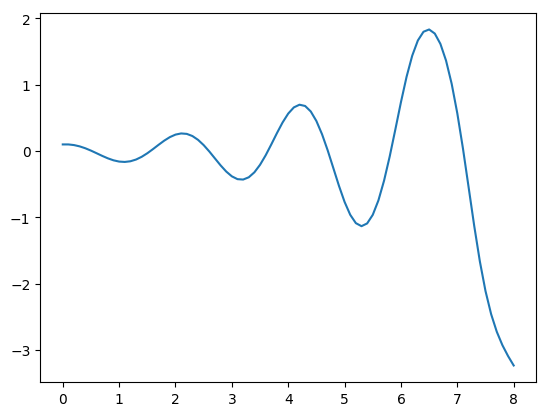

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f19df8b2e10>

In [8]:
x0 = [0.1; 0]
xs, ts = pendulum_forward_euler(pendulum_dynamics, x0, 8, 0.1)
plot(ts, xs[1, :])

We can see that the solution blows up which we can confirm by checking the eigenvalues of the jacobian matrix, at $x=0$. Since now we are using a discrete dynamics function $f_d$, we need to evaluate the jacobian matrix using these discrete dynamics: 
$$  x_{k+1} = f_d(x_k, u_k) = x_k + hf(x_k, u_k) \\
A_d = \frac{\partial f_d}{\partial x_k} = I + hA$$
We know that the real part of the eigen values of our $A$ matrix must be less than zero in order for the nonlinear system to be stable. Similarly, for a discrete system, we need the eigenvalues of $A_d$ to be within the unit circle, $|eig(A_d)| < 1$.

In [9]:
eigvals(pendulum_jacobian(0) + Array(I(2)))

2-element Vector{ComplexF64}:
 1.0 - 3.1320919526731656im
 1.0 + 3.1320919526731656im

## Runge-Kutta Fourth Order Method
Euler's method fits a line segment over each time step. We can use a better explicit integrator that fits a cubic polynomial called Runge Kutta 4-th order method. The basic idea is to compute several different "segment quantities" and apply a weighted average: 
$$
x_{k+1} = f_{RK4}(x_k) \\
    k_1 = f(x_k)\\
    k_2 = f\left(x_k + \frac{h}{2}k_1\right)\\
    k_3 = f\left(x_k + \frac{h}{2}k_2\right)\\
    k_4 = f(x_k + hf(x_k)) \\
x_{k+1} = x_k + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)
$$

In [27]:
function fd_pendulum_rk4(fun, xk, h)
    k1 = fun(xk)
    k2 = fun(xk + 0.5*h*k1)
    k3 = fun(xk + 0.5*h*k2)
    k4 = fun(xk + h*k3)
    return xk + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
end

function pendulum_rk4(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= fd_pendulum_rk4(fun, x_hist[:,k], h)
    end
    
    return x_hist, t
end

pendulum_rk4 (generic function with 2 methods)

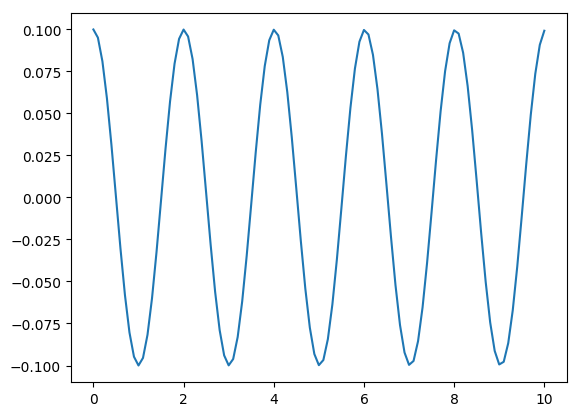

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1970672d30>

In [28]:
x0 = [0.1, 0]
xs2, ts2 = pendulum_rk4(pendulum_dynamics, x0, 10, 0.1)
plot(ts2, xs2[1, :])

We can see that this is a much more stable integrator. If we again look at the discrete jacobian's eigenvalues, we can see that for sufficiently small time steps the solution is stable, which is different from the Euler method, which essentially had eigenvalues above one at every time step we choose. 

# Implicit Integrators
We can also write the dynamics in "implicit" form: 
$$ f_d(x_{k+1}, x_k, u_k) = 0 $$

## Backward Euler
An example is the "backward Euler" approach: 
$$x_{k + 1} = x_k + hf(x_{k+1}).$$
This requires solving a rootfinding problem in $x_{k+1}$ to solve: 
$$ f_d(x_{k+1}, x_k, u_k) = x_k + hf(x_{k+1}) - x_{k+1} = 0.$$


In [12]:
function pendulum_backward_euler(fun, x0, Tf, dt)
    t = Array(range(0,Tf,step=dt))
    
    xs = zeros(length(x0),length(t))
    xs[:,1] .= x0
    
    # for all time steps, 
    for k = 1:(length(t)-1)
        # initialize error at 1
        e = 1
        # initialize next state guess as current state
        xs[:,k+1] = xs[:,k]
        # while error is not 0
        while e > 1e-8
            # solve the backward euler equation
            xk = xs[:,k] + dt.*fun(xs[:,k+1])
            # calculate error between backward pass and future step as shown in implicit equation 
            e = norm(xk - xs[:,k+1])
            # update future step
            xs[:,k+1] .= xk
        end
    end
    
    return xs, t
end

pendulum_backward_euler (generic function with 1 method)

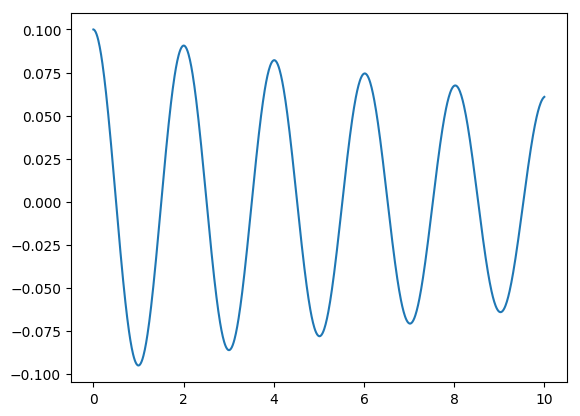

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f19df848cc0>

In [13]:
x0 = [.1; 0]
xs3, ts3 = pendulum_backward_euler(pendulum_dynamics, x0, 10, 0.01)
plot(ts3, xs3[1,:])

The above method of describing $x_{k+1}$ uses what is called the "fixed point" method, which sets the initial guess for $x_{k+1}$ as the current state $x_k$. Because at each time step we need to perform a rootfinding approach in order to obtain the future state, we must take care in choosing this method. 

## Newton's Method
In order to obtain the future state $x_{k+1}$, we can use a rootfinding technique, like Newton's method to solve the equation:
$$ f_d(x_{k+1}, x_k, u_k) = 0. $$
The root finding problem statement is given $f(x)$, find $x^*$ such that $f(x^*) = 0$. Newton's method uses the first order Taylor approximation 
$$ f(x + \Delta x) \approx f(x) + \frac{\partial f}{\partial x} \bigg \rvert_x \Delta x = 0 \\
\Delta x \gets -\left( \frac{\partial f}{\partial x} \right)^{-1} f(x)\\
x \gets x + \Delta x.$$
We repeat these steps until convergence. 
If we apply this to the backward Euler method, we can see that it looks slightly different during each solution step. 

In [14]:
function backward_euler_step_newton(fun, x0, h)
    # initial guess is the current state
    xk = x0
    # we are finding the value of xk that makes r = 0
    r = x0 + h.*fun(xk) - xk
    # record value of r; should be close to 0
    e = [norm(r)]
    while e[end] > 1e-8
        # use ForwardDiff to take the jacobian of the root r with respect to xk (using anonymous function)
        ∂r = ForwardDiff.jacobian(x -> x0 + h.*fun(x) - x, xk)
        # update xk based on our update rule Δx = -(∂f/∂x)^-1 * f(x)
        xk = xk - ∂r\r
        # update the root based on the most recently calculated xk
        r = x0 + h.*fun(xk) - xk
        # check how close it is to zero
        e = [e; norm(r)]
    end
    
    return xk, e
end  


function backward_euler_newton(fun, x0, Tf, h)
    t = Array(range(0,Tf,step=h))
    
    xs = zeros(length(x0),length(t))
    xs[:,1] .= x0
    
    for k = 1:(length(t)-1)
        xs[:,k+1], e = backward_euler_step_newton(fun, xs[:,k], h)
    end
    
    return xs, t
end

backward_euler_newton (generic function with 1 method)

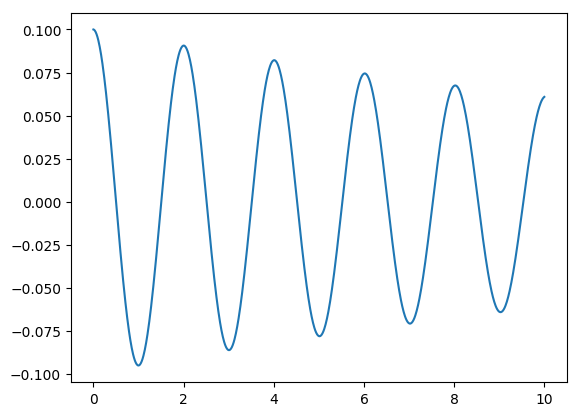

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f197069c780>

In [15]:
x0 = [.1; 0]
xs4, ts4 = backward_euler_newton(pendulum_dynamics, x0, 10, 0.01)
plot(ts4, xs4[1,:])

## Implicit Midpoint method

Another example of an implicit indegrator is an implicit midpoint method: 
$$ x_{k+1} = x_k + hf\left(\frac{x_{k+1} + x_k}{2}\right) $$
Which can be written in implicit form as: 
$$ x_k + hf\left(\frac{x_{k+1} + x_k}{2}\right) - x_{k+1} = 0.$$

Which means that a Newton method step will search for the value of $x_{k+1}$ such that $f_{Mid}(x_k, x_{k+1}) = 0$: 
$$
f_{Mid}(x_{k+1} + \Delta x) \approx f_{Mid}(x_{k+1}) + \frac{\partial f_{Mid}}{\partial x} \bigg\rvert_{x_{k+1}} \Delta x = 0 \\
\Delta x \gets - \left(\frac{\partial f_{Mid}}{\partial x}\right)^{-1} f_{Mid}(x_{k+1}) \\
x_{k+1} \gets x_{k+1} + \Delta x.
$$

In [16]:
# the integrator takes in dynamics and outputs new state
function implicit_midpoint_pendulum(x2, x1, h)
    out = zero(x2)
    
    # calculate the integration update
    xmid = 0.5 * (x1 + x2)
    # broadcasts addition across all inputs with .+ 
    out = x1 .+ h*pendulum_dynamics(xmid)
end

# we need the jacobian with respect to x2
function implicit_midpoint_jacobian2(x2, x1, h)
    # Jacobian wrt x2
    xmid = 0.5* (x2 + x1)
    h*pendulum_jacobian(xmid) * 0.5 - I
end

# newtons method outputs vector float array
function midpoint_newton_solve!(x2, x1, h; ϵ=1e-6)::Vector{Float64}
    # calculate residuals
    e = Float64[]
    
    # first calculate root expression r(x) = f(xk) - xk
    r(xk) = implicit_midpoint_pendulum(xk, x1, h) - xk
    ∇r(xk) = implicit_midpoint_jacobian2(xk, x1, h)
    
    for i = 1:10
        # evaluate residual and check for convergence
        res= r(x2) 
        # modify e in place by pushing the norm
        push!(e, norm(res))
        if norm(res) < ϵ
            break
        end
        
        # if no convergence, take a Newton step
        Δx = -∇r(x2)\ res
        x2 .+= Δx
    end
    return e
end

midpoint_newton_solve! (generic function with 1 method)

Now we can perform an energy analysis with this implicit integration method like so, and plot the energy of the system vs time: 
$$ E = \frac{1}{2} ml^2\omega^2 + mgl(1 - cos\theta) $$. 
We start with inital state of 45 degree rotation and zero velocity, $[0.7854, 0]^T$. 

In [17]:
# calculate pendulum energy
function pendulum_energy(x; m=1, l=1, g=9.81)
    return 0.5*m*l^2*x[2]^2 + m*g*(1-cos(x[1]))
end

pendulum_energy (generic function with 1 method)

In [18]:
function simulate(x0, h, T)
    time = range(0, T, step=h)
    x = copy(x0)
    x_next = zero(x)
    X = [zero(x0) for t in time]
    X[1] .= x0
    
    for i = 1:length(time) - 1
        midpoint_newton_solve!(X[i + 1], X[i], h, ϵ=1e-12)
    end
    return time, X
end

simulate (generic function with 1 method)

In [19]:
x0 = [deg2rad(45), 0]
@time time, X = simulate(x0, 0.1, 3600)
energy_implicit = pendulum_energy.(X);

  0.614459 seconds (3.72 M allocations: 278.075 MiB, 30.72% gc time, 47.82% compilation time)


Now we can plot the energy and the system to show what the implicit integrator results in.

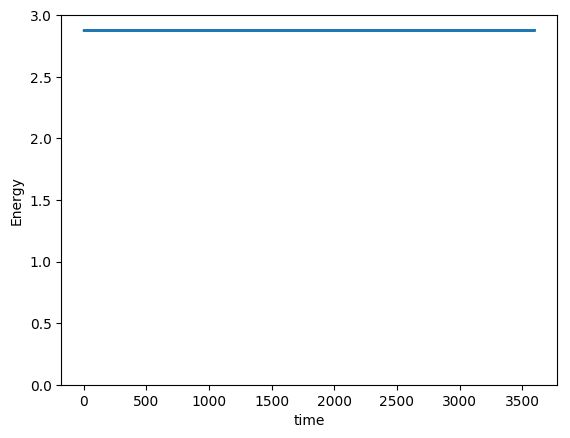

(0, 3)

In [20]:
plot(time, energy_implicit)
xlabel("time")
ylabel("Energy")
ylim([0, 3])

We can see that the midpoint implicit integrator doesn't lose any energy when simulating the system. This means it is a _symplectic_ integrator. 

In [21]:
function rk4(x, h)
    # TODO: implement
    xnext = zero(x)
    
    # SOLUTION
    k1 = pendulum_dynamics(x)
    k2 = pendulum_dynamics(x + 0.5*h*k1)
    k3 = pendulum_dynamics(x + 0.5*h*k2)
    k4 = pendulum_dynamics(x + h*k3)
    xnext = x + 1//6 * (k1 + 2k2 + 2k3 + k4) * h
    
    return xnext
end

function simulate_rk4(x0, h, T)
    time = range(0,T, step=h)
    x = copy(x0)
    x_next = zero(x)
    X = [zero(x0) for t in time]
    X[1] .= x0
    for i = 1:length(time) - 1
        X[i+1] .= rk4(X[i], h)
    end
    return time, X
end

simulate_rk4 (generic function with 1 method)

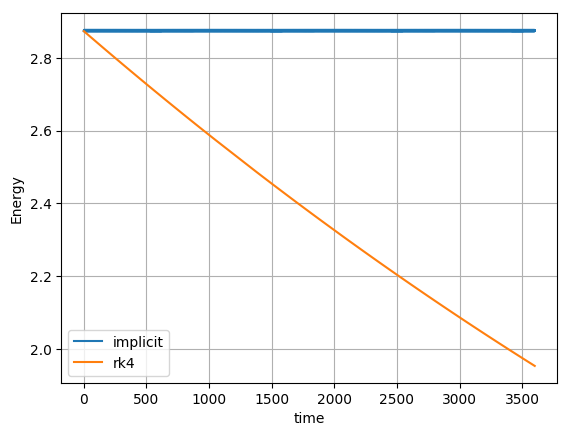

PyObject <matplotlib.legend.Legend object at 0x7f19705e98d0>

In [22]:
time, Xrk4 = simulate_rk4(x0, 0.1, 3600);
energy_rk4 = pendulum_energy.(Xrk4)
plot(time, energy_implicit, label="implicit")
plot(time, energy_rk4, label="rk4")
xlabel("time")
ylabel("Energy")
grid()
legend()

_Content adapted from Zac Manchester's Optimal Control and Reinforcement Learning class at Carnegie Mellon University_.